In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

0. Set Hyperparamters

In [3]:
train_ratio = 0.8
validation_ratio = 0.2
epochs = 100
batch_size = 1024

1. Import Data

In [4]:
# 1. Import data
NY_data = pd.read_csv("data/NY_data.csv")

# 2. Split data into x and y values
y = NY_data['price']
X = NY_data.drop(columns=['price'])

[0.04550615 0.0217133  0.31573447 0.25637654 0.36066953]


In [ ]:
# 3. Discard irrelivant features using ExtraTreeClassifier
clf = ExtraTreesClassifier(n_estimators=5)
clf = clf.fit(X, y)
print(clf.feature_importances_ )

# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(X)

In [ ]:
# 4. Split data into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

# 5. Normalize data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_norm = X_scaler.fit_transform(X_train)
X_val_norm = X_scaler.transform(X_val)
X_test_norm = X_scaler.transform(X_test)

y_train_norm = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

In [14]:
DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

DNN.compile(loss='mse', optimizer='adam')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2. Model Initilization

In [15]:
history = DNN.fit(X_train_norm, y_train_norm, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val_norm, y_val_norm), callbacks=[early_stop])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.9087 - val_loss: 3.2794
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9021 - val_loss: 3.0470
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0245 - val_loss: 2.8477
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8380 - val_loss: 2.6579
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6507 - val_loss: 2.4753
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5548 - val_loss: 2.3039
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9283 - val_loss: 2.1656
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8827 - val_loss: 1.9889
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1908 - val_loss: 1.8659
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3664 - val_loss: 1.7672
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6987 - val_loss: 1.7142
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

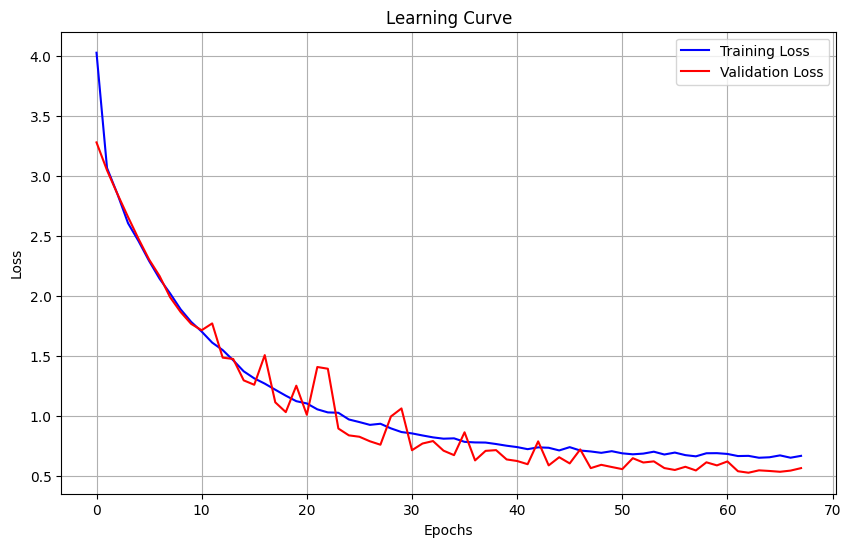

In [16]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
loss = DNN.evaluate(X_test_norm, y_test_norm)
print("Test Loss:", loss)

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.3835
Test Loss: 0.4508804678916931


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = y_scaler.inverse_transform(DNN.predict(X_test_norm))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
Mean Absolute Error: 355448.35601788
Mean Squared Error: 1526662185323.6604
Root Mean Squared Error: 1235581.7194033184
R-squared: 0.5031559024801098


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
predictions = DNN.predict(X_test_norm)
predictions = y_scaler.inverse_transform(predictions)
print("Expected Prices:", ", ".join(str(expected) for expected in y_test.iloc[:5]))
print("Predicted Prices:", " ".join(str(predicted) for predicted in predictions[:5, 0]))

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Expected Prices: 119900.0, 449999.0, 549999.0, 449000.0, 250000.0
Predicted Prices: 372396.12 752443.9 587989.25 578763.5 855703.4
